<a href="https://colab.research.google.com/github/bandreibal/autoencoders/blob/main/Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Autoencoder Variacional con Keras

En este notebook vamos a ver cómo podemos implementar un autoencoder variacional paso a paso.

Referencias:
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
* http://www.cs.us.es/~fsancho/?e=232
* https://www.jeremyjordan.me/variational-autoencoders/

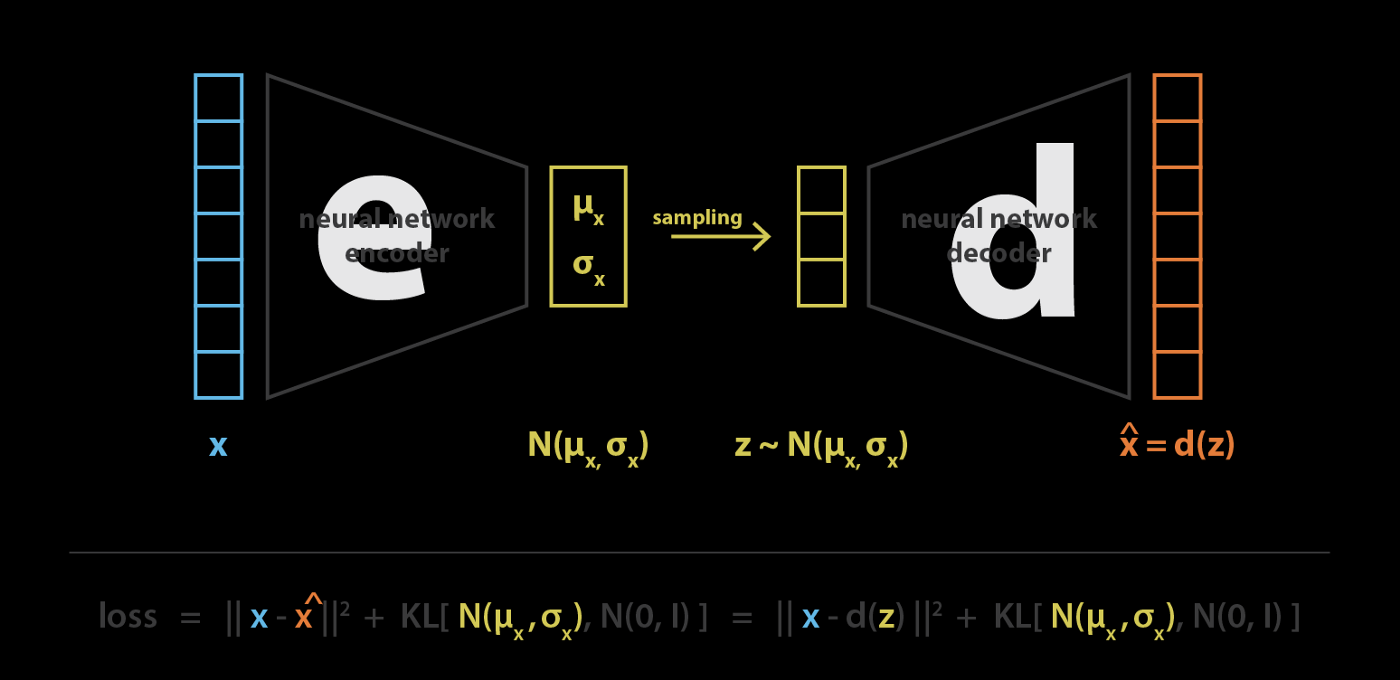

En ella podemos observar como, al igual que el autoencoder básico, consta de dos bloques: el encoder y el decoder.

Por una parte, el **encoder** toma los datos de entrada y los comprime en una representación mucho más compacta.

Por la otra, el **decoder** coge esa representación (o codificación) comprimida y trata de reconstruir los datos originales con el menor error posible.

La única diferencia es que el encoder, en este caso, no produce un "punto" en el espacio reducido, sino que produce una distribución de probabilidad. Es mediante el muestreo de esta distribución de probabilidad como somos capaces de regenerar los datos de entrada al introducirle la muestra obtenida al decoder.

**¡Comenzemos!**

Vamos a construir el AutoEncoder Variacional más simple posible:

In [1]:
import keras
from keras import layers

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))

h = layers.Dense(intermediate_dim, activation='relu')(inputs)

z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [2]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [3]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [4]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [5]:
import numpy as np
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/100
1875/1875 [==============================] - 13s 4ms/step - loss: 184.5936 - val_loss: 166.4901
Epoch 2/100
1875/1875 [==============================] - 8s 4ms/step - loss: 164.8943 - val_loss: 163.5523
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 162.4827 - val_loss: 161.6174
Epoch 4/100
1875/1875 [==============================] - 8s 4ms/step - loss: 160.4601 - val_loss: 159.7444
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 158.7025 - val_loss: 158.3836
Epoch 6/100
1875/1875 [==============================] - 8s 4ms/step - loss: 157.3319 - val_loss: 156.9357
Epoch 7/100
1875/1875 [==============================] - 8s 4ms/step - loss: 156.1271 - val_loss: 155.8994
Epoch 8/100
1875/1875 [==============================] - 7s 4ms/step - loss: 155.0412 - val_loss: 154.8668
Epoch 9/100
1875/1875 [==============================] - 8s 4ms/step - loss: 1

In [6]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=32)

313/313 [==============================] - 1s 1ms/step


In [7]:
x_test_encoded = np.asarray(x_test_encoded)

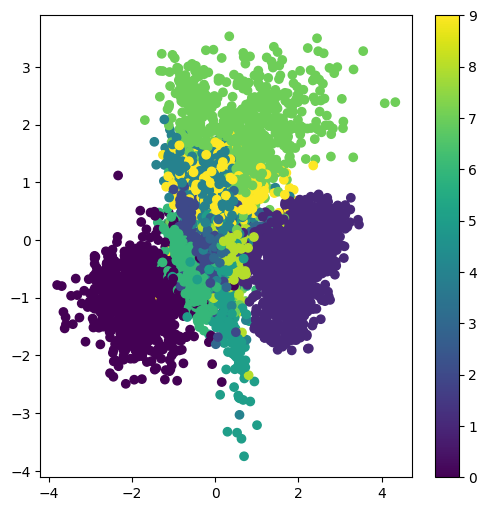

In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

1/1 [==============================] - ETA: 0s

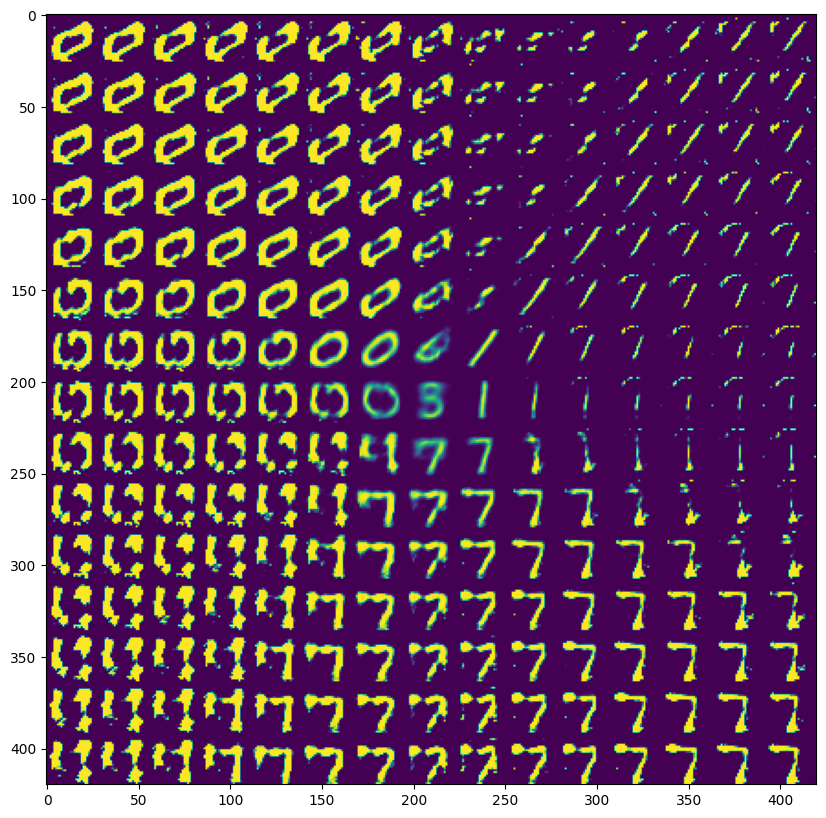

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()